# Goal: 
Predict if a passenger will survived or not.

# 1. Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

# 2. Collecting the data

- data to train the model

In [2]:
train = pd.read_csv('dataset/train.csv')

- data to predict

In [3]:
test = pd.read_csv('dataset/test.csv')

# 3. Exploratory data analysis

In [4]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### Data Dictionary

- Survived: <br>
    0 = No; 1 = Yes
- pclass (Ticket class): <br> 
    1 = 1st; 2 = 2nd; 3 = 3rd
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- fare: Passenger fare
- ticket: Ticket number
- cabin: Cabin number
- embarked (Port of Embarkation): <br>
    C = Cherbourg; Q = Queenstown; S = Southampton

## train dataset:

In [6]:
train.shape

(891, 12)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### train information
- There are 891 rows and 12 columns;
- We can see some _missing values_ in **train** dataset: `Age`, `Cabin`, and `Embarked`

## test dataset:

In [9]:
test.shape

(418, 11)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### test information
- There are 418 rows and 11 columns, which means we need predict 418 rows.
- Test has no target column, which is 'Survived'
- We can see some _missing values_ in **test** dataset: `Age`, `Fare`, and `Cabin`

# 4. Visualization

### Correlation between features

In [12]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


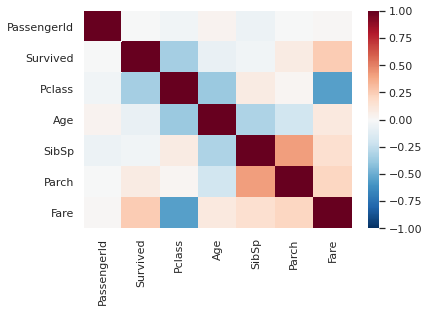

In [19]:
sns.heatmap(train.corr(), cmap="RdBu_r", vmax=1, vmin=-1)
plt.show()

The strongest correlations between the features are:
- `Pclass` and `Fare`
- `SibSp` and `Parch`

which make sense if we see what these features means.
<br>
<br>

In [24]:
train.corr()[['Survived']].drop('Survived')

,Survived
PassengerId,-0.005007
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
Parch,0.081629
Fare,0.257307


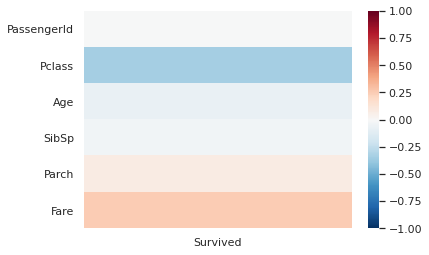

In [25]:
sns.heatmap(train.corr()[['Survived']].drop('Survived'), cmap="RdBu_r", vmax=1, vmin=-1)
plt.show()

- `Pclass` and `Fare` are the two feature more correlated with `Survived`.

### Bar chart for categorical features

convert this graph to compare in a proporcional way. Like the percentagem of people who survived or not. Because, we don't know if there are more women, more 3rd class people and so on.

In [ ]:
def bar_chart(feature):
    
    '''a bar chart to analyse how many people survided or not 
    given a feature'''
    
    # the qty of people (survived) for each feature value
    survived = train[train.Survived==1][feature].value_counts()
    dead = train[train.Survived==0][feature].value_counts()
    
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    
    df.plot(kind='bar', stacked=True, figsize=(10,5))

#### Sex

In [ ]:
bar_chart('Sex')

- Most of survived people was women.
- Survived more women that man. 
- Dead more man than women.

#### Pclass

In [ ]:
bar_chart('Pclass')

- The 1st and 3rd class people more survived than 2 class.
- The 3rd class people more dead than other classes.

**Observation** <br>
The 3rd class is significantily present in both groups. Is it because the quantity of people? <br>
Peharps it would be better to make this graph proportionally -- like: what percentage of first class survivors?

#### SibSp

In [ ]:
bar_chart('SibSp')

#### Parch

In [ ]:
bar_chart('Parch')

#### Embarked

In [ ]:
bar_chart('Embarked')

# 5. Feature Engineering

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself ([wikipedia](https://en.wikipedia.org/wiki/Feature_engineering)). <br>
Algorithms in machine learning require a numerical representation of objects, because it facilitates the processing and statistical analysis. <br>
<br>
Examples
- Derive new features using existing features
- Remove irrelevant features (Feature Selection)
- Transform existing features
- Encoding categorical variables (Feature Encoding)
<br>

**Keep in mind the features with missing values: `Age`, `Cabin`, `Fare`, and `Embarked`**
<br>
<br>

In [ ]:
all_data = [train, test]

### 5.1 Name (Honorifics: Mr, Miss, Mrs)

In [ ]:
train[['Name']].tail()

- How `Name` feature can be useful? <br>
If we get the information about Title, we can use it in `Age` missing values.

In [ ]:
# get an expression beginning with a space + 1 or more letters + '.' in the end.
for dataset in all_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
train['Title'].value_counts()

In [ ]:
test['Title'].value_counts()

- As we see most of people in train and test dataset are treated like`Mr`, `Miss` or `Mrs`.  So let's categorize them with numerical values...

But before do that, as we'll use it to fill age missing values, let's see where there are missing values in the datasets

In [ ]:
train_age_nan = train[train.isnull()[['Age']].any(axis=1)]

(train_age_nan
     .groupby('Title')
     .count()[['PassengerId']]
     .sort_values('PassengerId', ascending=False))

In [ ]:
test_age_nan = test[test.isnull()[['Age']].any(axis=1)]

(test_age_nan
     .groupby('Title')
     .count()[['PassengerId']]
     .sort_values('PassengerId', ascending=False))

- Most of them (missing age values) is part of the largest title groups.

### Converting `Title` to a numerical variable (categorical nominal)

**Title map** <br>
Mr : 0 <br>
Miss : 1 <br>
Mrs : 2 <br>
Others : 3

In [ ]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3}

for dataset in all_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

In [ ]:
train['Title'].value_counts()

In [ ]:
test['Title'].value_counts()

In [ ]:
bar_chart('Title')

- Most of suvivors have the `Miss` and `Mrs` title. (women)
- Most of the dead were treated like `Mr`. (men)

### Removing `Name` feature
they are no longer needed, because the `Title` is more important

In [ ]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

## 5.2 Sex

### Converting `Sex` to a numerical variable (categorical nominal)

**Sex map** <br>
male: 0 <br>
female: 1

In [ ]:
sex_mapping = {'male': 0, "female": 1}

for dataset in all_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

## 5.3 Age

### Handle with missing values

Decision: filling missing `Age` values with *average age* for each title (Mr, Mrs, Miss, Others)

- Concat all data to get a median for Age title. <br>
Why? Because we can get a better average from a larger and more diverse dataset. If we do it separately, as test is a smaller sample, the age average can be very different. <br>
OBS: when concat it, don't change the indexes, the real ones will be necessary to the next step. I'll use them to find the limit to filna on train and test datasets.

In [ ]:
all_title_age_data = pd.concat([train[['Title', 'Age']], test[['Title', 'Age']]])

print(all_title_age_data.shape)
print(len(train) + len(test))

In [ ]:
all_title_age_data.tail(2)

In [ ]:
all_title_age_data[['Age']].head(10)

In [ ]:
age_median = all_title_age_data.groupby('Title')['Age'].transform('median')

age_median.head(10)

- Goal example: fill #5 (missing value) with 29.

In [ ]:
train['Age'].fillna(age_median[:len(train)], inplace=True)
test['Age'].fillna(age_median[len(train)+1:], inplace=True)

In [ ]:
train[['Age']].head(6)

- #5 = 29

In [ ]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

**- Analysis:** <br>
There is no big difference between the age of most survivors and most of people who died. <br>
Probably because most of people in the Titanic had this mean age (between 15 and 45). <br>
<br>
More people survived than died between ~ 17 and 33 yo. <br>
More people died than survived between 0 and 17 yo.

<br>
<br>

In [ ]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlim(10, 40)

In [ ]:
train.info()

In [ ]:
test.info()

- `Age` feature no longer has missing values.

### Converting Age to a numerical variable (categorical ordinal)

**Age map** <br>
child: 0 <br>
young: 1 <br>
adult: 2 <br>
mid-age: 3 <br>
senior: 4 <br>

In [ ]:
for dataset in all_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

In [ ]:
train.head(2)

In [ ]:
test.head(2)

In [ ]:
bar_chart('Age')

In [ ]:
train[train.Age == 4].groupby('Survived').count()[['PassengerId']]

In [ ]:
train.groupby(['Age', 'Survived']).count()[['PassengerId']]

## 5.4 Embarked

### Handle with missing values

What is the most common Port of Embarkation? S! <br>
Decision: after see the most common port is 'S' in each Pclass and both datasets (train and test), filling missing embarked values with 'S'.

In [ ]:
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])

df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

plt.show()

In [ ]:
Pclass1 = test[test['Pclass']==1]['Embarked'].value_counts()
Pclass2 = test[test['Pclass']==2]['Embarked'].value_counts()
Pclass3 = test[test['Pclass']==3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])

df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

plt.show()

- We can see that in test dataset the 1st class is 'balanced' between S and Q ports. However, if we join with train dataset, the 1st class will have S as the most used port.

In [ ]:
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

### Converting Embarked to a numerical variable (categorical nominal)

**embarked map** <br>
S = 0 <br>
C = 1 <br>
Q = 2

In [ ]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}

for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [ ]:
train.head(2)

## 5.5 Fare

### Handle with missing values

Decision: filling missing Fare with the median Fare for each pclass.

In [ ]:
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [ ]:
train.head(2)

In [ ]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
 
plt.show()

In [ ]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
plt.xlim(0, 20)

In [ ]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
plt.xlim(0, 30)

In [ ]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
plt.xlim(0)

### Converting Fare to numerical variable (categorical ordinal)

In [ ]:
for dataset in all_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

In [ ]:
train.head()

## 5.6 Cabin

Understading the distribution

In [ ]:
train.Cabin.value_counts().head()

### Converting Cabin value to numerical values (categorical nominal)

Decision: use just the first Cabin letter.

In [ ]:
for dataset in all_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

In [ ]:
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])

df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

In [ ]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}

for dataset in all_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

### Handle with missing values

Decision: filling missing Cabin with the median Cabin for each pclass.

In [ ]:
# fill missing Fare with median fare for each Pclass
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

In [ ]:
train.head()

## 5.7 Family Size

New feature

In [ ]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

In [ ]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'FamilySize',shade= True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()
plt.xlim(0)

### Categorizing the Family feature (categorical ordinal)

In [ ]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}

for dataset in all_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

## 5.8 Removing unnecessary features

In [ ]:
features_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

## 5.9 Creating train_data, test_data, and target dataframes

In [ ]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

train_data.shape, target.shape

In [ ]:
train_data.head(2)

In [ ]:
target.head(2)

In [ ]:
test_data = test.drop('PassengerId', axis=1).copy()

In [ ]:
test_data.head(2)

# 6. Modeling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import auc, roc_curve, precision_recall_curve

import numpy as np

In [ ]:
train_data.info()

In [ ]:
def area_under_curve_graph (clf, train_data, target):
    
    y_pred_prob = cross_val_predict(clf, train_data, target, cv=k_fold, n_jobs=1, method='predict_proba')
    
    # TPR = Recall = TP / (TP + FN)
    # FPR = FP / (FP + TN)

    false_positive_rate, true_positive_rate, threshold = roc_curve(target, y_pred_prob[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize = (8,8))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(false_positive_rate, true_positive_rate, color = 'green', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [ ]:
def prediction_recall_curve_graph (clf, train_data, target):

    y_pred_prob = cross_val_predict(clf, train_data, target, cv=k_fold, n_jobs=1, method='predict_proba')
    
    # Recall = TP / (TP + FN) What proportion of actual positives was identified correctly?
    # Precision = TP / (TP + FP) What proportion of positive identifications was actually correct?
    
    precision, recall, thresholds = precision_recall_curve(target, y_pred_prob[:,1])
    pr_aucRF = auc(recall, precision)
    plt.figure(figsize = (8,8))
    plt.title('Precision Recall Curve')
    plt.plot(recall, precision, color = 'red', label = 'PR AUC = %0.2f' % pr_aucRF)
    plt.legend(loc = 'lower right')

    # no_skill = Count of P / Total count
    no_skill = len(target[target==1]) / len(target)
    plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

    # Get best threshold
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    print('\n')
    plt.plot(recall[ix], precision[ix], marker='o', color='black', label='Best')

    plt.axis('tight')
    plt.ylabel('Precision')
    plt.xlabel('Recall')

## 6.1 Cross Validation (k-fold)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## 6.2 KNN

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=13)
scoring = 'accuracy'
score = cross_val_score(clf_knn, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

In [ ]:
round(np.mean(score)*100,2)

In [ ]:
area_under_curve_graph(clf_knn, train_data, target)

In [ ]:
prediction_recall_curve_graph(clf_knn, train_data, target)

## 6.3 Decision tree

In [ ]:
clf_dt = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf_dt, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

In [ ]:
round(np.mean(score)*100,2)

In [ ]:
area_under_curve_graph(clf_dt, train_data, target)

In [ ]:
prediction_recall_curve_graph(clf_dt, train_data, target)

## 6.4 Random Forest

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf_rf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

In [ ]:
round(np.mean(score)*100,2)

In [ ]:
area_under_curve_graph(clf_rf, train_data, target)

In [ ]:
prediction_recall_curve_graph(clf_rf, train_data, target)

## 6.5 Naive Bayes

In [ ]:
clf_gnb = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf_gnb, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

In [ ]:
round(np.mean(score)*100, 2)

In [ ]:
area_under_curve_graph(clf_gnb, train_data, target)

In [ ]:
prediction_recall_curve_graph(clf_gnb, train_data, target)

## 6.6 SVM

In [ ]:
clf_svm = SVC(gamma='scale')
scoring = 'accuracy'
score = cross_val_score(clf_svm, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

In [ ]:
round(np.mean(score)*100,2)

In [ ]:
clf_svm_t = SVC(gamma='scale', probability=True)
area_under_curve_graph(clf_svm_t, train_data, target)

In [ ]:
prediction_recall_curve_graph(clf_svm_t, train_data, target)

# 7. Applying the best algorithm SVM or KNN

for this case SVM was the algorithm with the best accuracy
and KNN have the best AUC

In [ ]:
clf = SVC(gamma='scale')
clf.fit(train_data, target)

prediction = clf.predict(test_data)

In [ ]:
## Kaggle challenge ask for passengerID and Survived

result = pd.DataFrame({'PassengerId': test['PassengerId'],
                      'Survived': prediction})

result.head()